In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm 

In [2]:
dataframe_final = pd.read_parquet('dados_webscraping/dataframe_imoveis_venda_pronto_para_predicao.parquet')

print(dataframe_final.shape)
display(dataframe_final.head(2))
print("Porcentagem de informações faltantes: ")
display(round(dataframe_final.isna().sum()/dataframe_final.shape[0] * 100, 2).astype(str) + " %")


(756, 29)


,url,endereco,preco,area,quartos,vagas_de_carro,valor_condominio,iptu,mobiliado,piscina,...,longitude,geometry,nome,distancia_metro,distancia_escola,distancia_unidade_saude,indic_rend,indic_lixo,indic_esgo,indic_agua
16,https://www.zapimoveis.com.br/imovel/venda-apa...,"Estrada da Água Branca, 3636 - Padre Miguel, R...",180000.0,47.0,2.0,1,320.0,1.0,False,False,...,-43.45155606319761,b'\x01\x01\x00\x00\x00\xa1\xe2\xcd\x96\xcc\xb9...,Padre Miguel,17537.451623,396.788803,1108.528016,2.604224,99.900690,96.065450,99.550742
17,https://www.zapimoveis.com.br/imovel/venda-apa...,"Rua Doutor Garnier, 1 - Rocha, Rio de Janeiro ...",315000.0,97.0,2.0,1,610.0,56.0,False,False,...,-43.247391227296404,b'\x01\x01\x00\x00\x008J\x07\x84\xaa\x9fE\xc0k...,Rocha,540.823757,205.886729,641.310384,4.647416,99.936061,99.680307,100.000000


Porcentagem de informações faltantes: 


url                        0.0 %
endereco                   0.0 %
preco                      0.0 %
area                       0.0 %
quartos                    0.0 %
vagas_de_carro             0.0 %
valor_condominio           0.0 %
iptu                       0.0 %
mobiliado                  0.0 %
piscina                    0.0 %
condominio                 0.0 %
elevador                   0.0 %
jardim                     0.0 %
quadra_esportiva           0.0 %
academia                   0.0 %
finalidade                 0.0 %
tipo                       0.0 %
localizacao                0.0 %
latitude                   0.0 %
longitude                  0.0 %
geometry                   0.0 %
nome                       0.0 %
distancia_metro            0.0 %
distancia_escola           0.0 %
distancia_unidade_saude    0.0 %
indic_rend                 0.0 %
indic_lixo                 0.0 %
indic_esgo                 0.0 %
indic_agua                 0.0 %
dtype: object

In [5]:
colunas_analise = ['preco', 'area', 'quartos', 'vagas_de_carro', 'valor_condominio',
                   'iptu', "mobiliado", "tipo", "distancia_metro", 'distancia_escola', 'distancia_unidade_saude',
                   'indic_rend', 'indic_lixo', 'indic_esgo', 'indic_agua']

display(dataframe_final[colunas_analise].info())

X = dataframe_final[colunas_analise].drop('preco', axis=1)  # Remover a coluna 'preco' de X
y = dataframe_final['preco']

<class 'pandas.core.frame.DataFrame'>
Index: 756 entries, 16 to 3859
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   preco                    756 non-null    float64
 1   area                     756 non-null    float64
 2   quartos                  756 non-null    float64
 3   vagas_de_carro           756 non-null    int64  
 4   valor_condominio         756 non-null    float64
 5   iptu                     756 non-null    float64
 6   mobiliado                756 non-null    bool   
 7   tipo                     756 non-null    object 
 8   distancia_metro          756 non-null    float64
 9   distancia_escola         756 non-null    float64
 10  distancia_unidade_saude  756 non-null    float64
 11  indic_rend               756 non-null    float64
 12  indic_lixo               756 non-null    float64
 13  indic_esgo               756 non-null    float64
 14  indic_agua               756 

None

In [7]:
# Separar colunas numéricas, categóricas e booleanas
colunas_numericas = X.select_dtypes(include=[np.number]).columns.tolist()
colunas_categoricas = X.select_dtypes(include=[object]).columns.tolist()
colunas_booleanas = X.select_dtypes(include=[bool]).columns.tolist()

# Criar o pré-processador com StandardScaler para colunas numéricas e OneHotEncoder para colunas categóricas e booleanas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colunas_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), colunas_categoricas + colunas_booleanas)
    ])

X_scaled = preprocessor.fit_transform(X)

In [8]:
X_scaled_df = pd.DataFrame(X_scaled, columns=preprocessor.get_feature_names_out())
pd.set_option('display.max_columns', None)
print(X_scaled_df.shape)
display(X_scaled_df.head(2))


(756, 16)


,num__area,num__quartos,num__vagas_de_carro,num__valor_condominio,num__iptu,num__distancia_metro,num__distancia_escola,num__distancia_unidade_saude,num__indic_rend,num__indic_lixo,num__indic_esgo,num__indic_agua,cat__tipo_apartamento,cat__tipo_casa,cat__mobiliado_False,cat__mobiliado_True
0,-1.374659,-0.557902,0.0,-1.335322,-0.970314,4.242209,-0.208012,0.126958,-2.221817,-0.190210,-3.077244,0.239077,1.0,0.0,1.0,0.0
1,0.260552,-0.557902,0.0,-0.754352,-0.904688,-0.515035,-1.092871,-0.786527,-1.476568,0.202177,0.707519,0.768711,1.0,0.0,1.0,0.0


In [9]:
parametros = {
    "Linear Regression": {},  # Sem hiperparâmetros para ajustar
    "Ridge Regression": {
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    },
    "Random Forest": {
        'model__n_estimators': [50, 100, 200, 300],
        'model__max_depth': [5, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    "Gradient Boosting": {
        'model__n_estimators': [50, 100, 200, 300],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
        'model__subsample': [0.8, 0.9, 1.0]
    }
}

modelos = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False),
    'MAPE': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    'R²': make_scorer(r2_score)
}

In [10]:
lista_com_resultados = []
resultados_modelos = {}

print("Treinando modelos com ajuste de hiperparâmetros...\n")

for nome, modelo in tqdm(modelos.items(), desc="Modelos treinados"):
    # Criar o pipeline
    pipeline = Pipeline([
        #('preprocessor', preprocessor),  # Pré-processador
        ('model', modelo)              # Modelo
    ])
    
    # Configurar o GridSearchCV (caso haja hiperparâmetros para ajustar)
    if parametros[nome]:  # Apenas modelos com hiperparâmetros definidos
        grid_search = GridSearchCV(
            pipeline, 
            param_grid=parametros[nome], 
            cv=5, 
            scoring={"MAE":"neg_mean_absolute_error",
                     "RMSE":"neg_root_mean_squared_error",
                     "MAPE": "neg_mean_absolute_percentage_error",
                     "R²":"r2"},  # Métrica principal
            refit="MAE",
            n_jobs=-1, 
            return_train_score=True
        )
        # Treinar o modelo
        grid_search.fit(X_scaled, y)
        lista_com_resultados.append({f"{modelo}" : grid_search.cv_results_})
                
        # Melhor modelo e desempenho
        melhor_modelo = grid_search.best_estimator_
        melhor_params = grid_search.best_params_
        melhor_mae = -grid_search.best_score_  # Negativo porque usamos 'neg_mean_absolute_error'
    else:
        # Para modelos sem hiperparâmetros (como Linear Regression)
        pipeline.fit(X_scaled, y)
        melhor_modelo = pipeline
        melhor_params = "Sem ajuste de hiperparâmetros"
        melhor_mae = "Não aplicável"
    
    # Executar validação cruzada com o melhor modelo
    resultados_cv = cross_validate(
        melhor_modelo, X_scaled, y, cv=5, scoring=scoring, return_train_score=False, n_jobs=-1
    )
    
    # Armazenar os resultados
    resultados_modelos[nome] = {
        'Melhores Parâmetros': melhor_params,
        'MAE': -resultados_cv.get('test_MAE', np.array(0)).mean(),
        'MAPE': -resultados_cv.get('test_MAPE', np.array(0)).mean(),
        'RMSE': -resultados_cv.get('test_RMSE', np.array(0)).mean(),
        'R²': resultados_cv.get('test_R²', np.array(0)).mean()
    }

Treinando modelos com ajuste de hiperparâmetros...



Modelos treinados:  75%|███████▌  | 3/4 [01:30<00:39, 39.38s/it]c:\Users\FVF0\OneDrive - PETROBRAS\Dev\zap-imoveis-scraping-prediction\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
Modelos treinados: 100%|██████████| 4/4 [02:24<00:00, 36.09s/it]


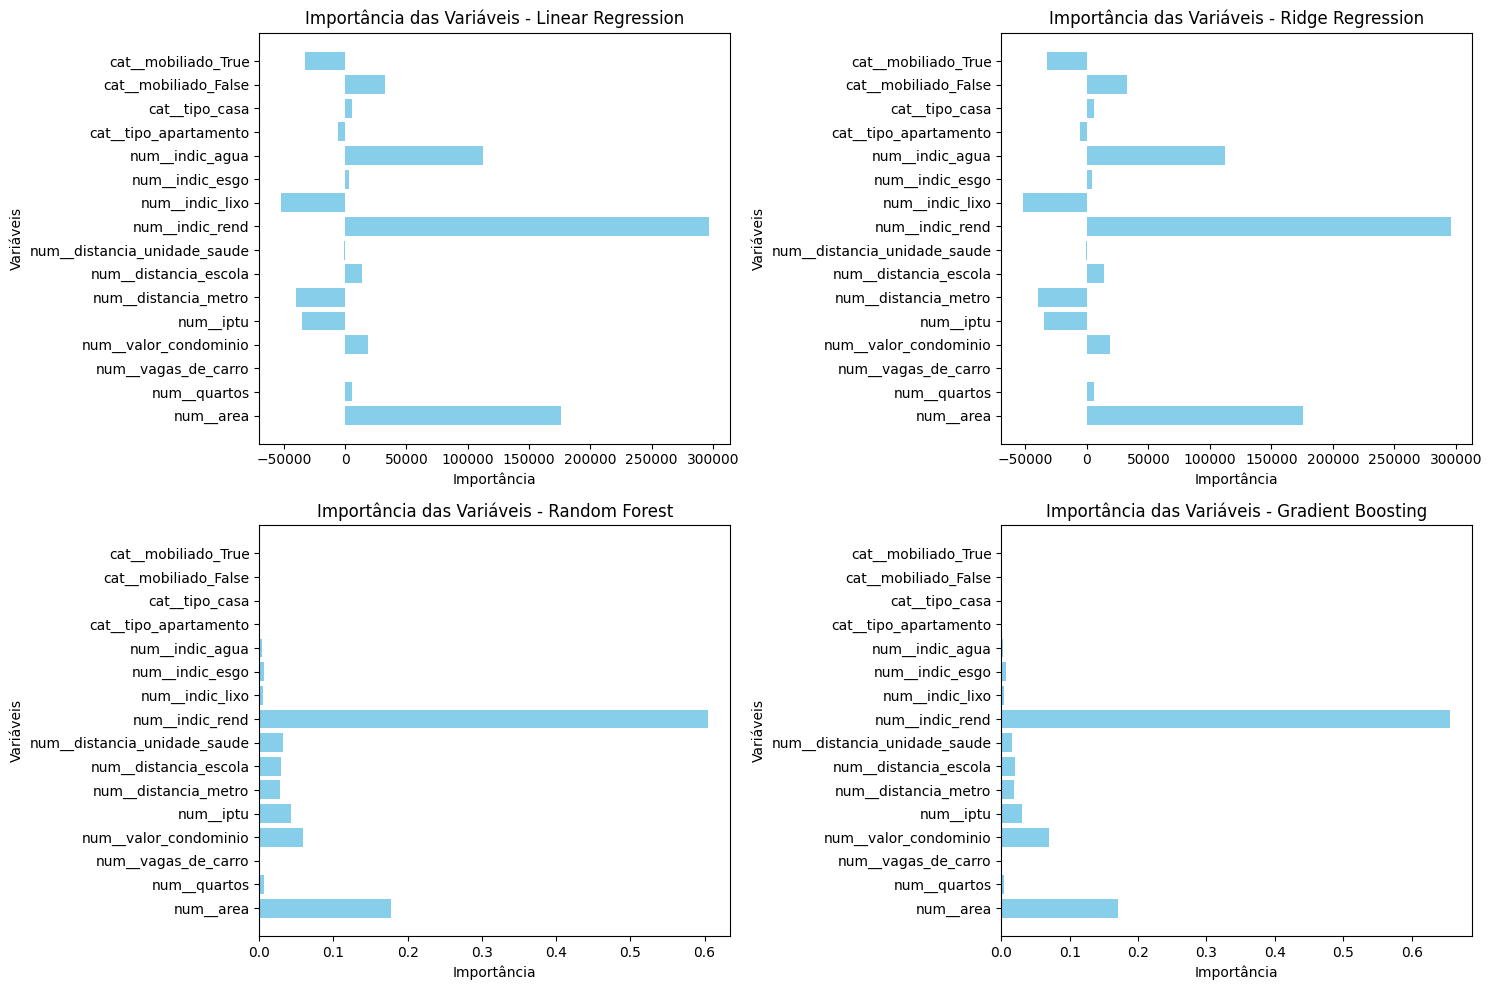

In [11]:
# Inicializar lista para armazenar importâncias
importancias_comparadas = pd.DataFrame()

# Definir o número de subgráficos
num_modelos = len(modelos)
num_colunas = 2  # 2 colunas
num_linhas = (num_modelos + 1) // num_colunas  # Calculando as linhas para acomodar os subgráficos

# Criar a figura e os subgráficos
plt.figure(figsize=(15, 5 * num_linhas))

for i, (nome, modelo) in enumerate(modelos.items()):
    plt.subplot(num_linhas, num_colunas, i + 1)
    
    modelo_treinado = modelo.fit(X_scaled_df, y)
    
    if nome in ["Linear Regression", "Ridge Regression"]:
        importancias = modelo_treinado.coef_
    elif nome in ["Random Forest", "Gradient Boosting"]:
        importancias = modelo_treinado.feature_importances_
    else:
        resultado_permutation = permutation_importance(
            modelo_treinado, X_scaled_df, y, n_repeats=10, random_state=42
        )
        importancias = resultado_permutation.importances_mean

    # Verificar alinhamento das dimensões
    if len(importancias) != len(X_scaled_df.columns):
        raise ValueError(
            f"Modelo {nome}: número de importâncias ({len(importancias)}) "
            f"diferente do número de colunas em X ({len(X_scaled_df.columns)})."
        )
    
    # Plotar a importância das variáveis
    plt.barh(X_scaled_df.columns, importancias, color='skyblue')
    plt.title(f'Importância das Variáveis - {nome}')
    plt.xlabel('Importância')
    plt.ylabel('Variáveis')

plt.tight_layout()
plt.show()


In [12]:
# Exibir os resultados
print("Resultados da validação cruzada com ajuste de hiperparâmetros:\n")
for nome, metricas in resultados_modelos.items():
    print(f"Modelo: {nome}")
    print(f"  Melhores Parâmetros: {metricas['Melhores Parâmetros']}")
    print(f"  MAE: {metricas['MAE']:.4f}")
    print(f"  MAPE: {metricas['MAPE']:.4f}\n")
    print(f"  RMSE: {metricas['RMSE']:.4f}")
    print(f"  R²: {metricas['R²']:.4f}\n")


# Resultados da validação cruzada com ajuste de hiperparâmetros:

# Modelo: Linear Regression
#   Melhores Parâmetros: Sem ajuste de hiperparâmetros
#   MAE: 203951.8620
#   RMSE: 279206.0217
#   R²: 0.7001

# Modelo: Ridge Regression
#   Melhores Parâmetros: {'model__alpha': 100.0}
#   MAE: 202109.9878
#   RMSE: 284986.7170
#   R²: 0.6905

# Modelo: Random Forest
#   Melhores Parâmetros: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
#   MAE: 156187.9344
#   RMSE: 238708.3449
#   R²: 0.7792

# Modelo: Gradient Boosting
#   Melhores Parâmetros: {'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 300, 'model__subsample': 0.8}
#   MAE: 155864.5529
#   RMSE: 234146.5369
#   R²: 0.7871



Resultados da validação cruzada com ajuste de hiperparâmetros:

Modelo: Linear Regression
  Melhores Parâmetros: Sem ajuste de hiperparâmetros
  MAE: 202190.0523
  MAPE: 32.9762

  RMSE: 279094.1639
  R²: 0.6762

Modelo: Ridge Regression
  Melhores Parâmetros: {'model__alpha': 100.0}
  MAE: 200409.7652
  MAPE: 32.0717

  RMSE: 283104.9002
  R²: 0.6684

Modelo: Random Forest
  Melhores Parâmetros: {'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 100}
  MAE: 158860.5371
  MAPE: 21.7652

  RMSE: 238110.6851
  R²: 0.7639

Modelo: Gradient Boosting
  Melhores Parâmetros: {'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 100, 'model__subsample': 0.8}
  MAE: 157185.1775
  MAPE: 21.5702

  RMSE: 237603.8390
  R²: 0.7654



In [13]:
# Dicionário para armazenar os resultados agrupados
resultados_agrupados = {}

# Iterar pelos dicionários na lista
for dicionario in lista_com_resultados:
    for algoritmo, metrica_dados in dicionario.items():
        # Inicializa o algoritmo no dicionário se não existir
        if algoritmo not in resultados_agrupados:
            resultados_agrupados[algoritmo] = {"MAE": [], "RMSE": [], "R²": [], "MAPE": []}

        # Processa cada métrica e valor
        for metrica, valor in metrica_dados.items():
            if "test" in metrica:
                if "MAE" in metrica:
                    resultados_agrupados[algoritmo]["MAE"].append(valor)
                elif "RMSE" in metrica:
                    resultados_agrupados[algoritmo]["RMSE"].append(valor)
                elif "R²" in metrica:
                    resultados_agrupados[algoritmo]["R²"].append(valor)
                elif "MAPE" in metrica:
                    resultados_agrupados[algoritmo]["MAPE"].append(valor)
# # Exibe os resultados agrupados
# for algoritmo, metricas in resultados_agrupados.items():
#     print(f"Resultados para {algoritmo}:")
#     for tipo, valores in metricas.items():
#         print(f"  {tipo}: {valores}")

In [14]:
import pandas as pd
import re

lista_de_dataframes = []
dataframe_original = pd.DataFrame(resultados_agrupados)

for coluna in dataframe_original.columns:

    df_exploded = dataframe_original[coluna].explode()
    
    df_melted = pd.DataFrame({
        'Métrica': df_exploded.index,
        'Valor': df_exploded.values
    })
    
    # Adicionar o nome do algoritmo extraído da coluna
    df_melted["Algoritmo"] = re.sub(r'\(.*?\)', '', coluna)
    lista_de_dataframes.append(df_melted)

# Concatenar todos os DataFrames da lista em um único DataFrame final
dataframe_final = pd.concat(lista_de_dataframes, ignore_index=True)
dataframe_final = dataframe_final.explode("Valor").reset_index(drop=True)
dataframe_final = dataframe_final[dataframe_final['Valor'] % 1 != 0]
display(dataframe_final)


,Métrica,Valor,Algoritmo
0,MAE,-175071.505836,Ridge
1,MAE,-175056.126575,Ridge
2,MAE,-174903.042268,Ridge
3,MAE,-173525.727859,Ridge
4,MAE,-168511.69639,Ridge
...,...,...,...
9227,MAPE,0.012617,GradientBoostingRegressor
9228,MAPE,0.015254,GradientBoostingRegressor
9229,MAPE,0.00842,GradientBoostingRegressor
9230,MAPE,0.012693,GradientBoostingRegressor


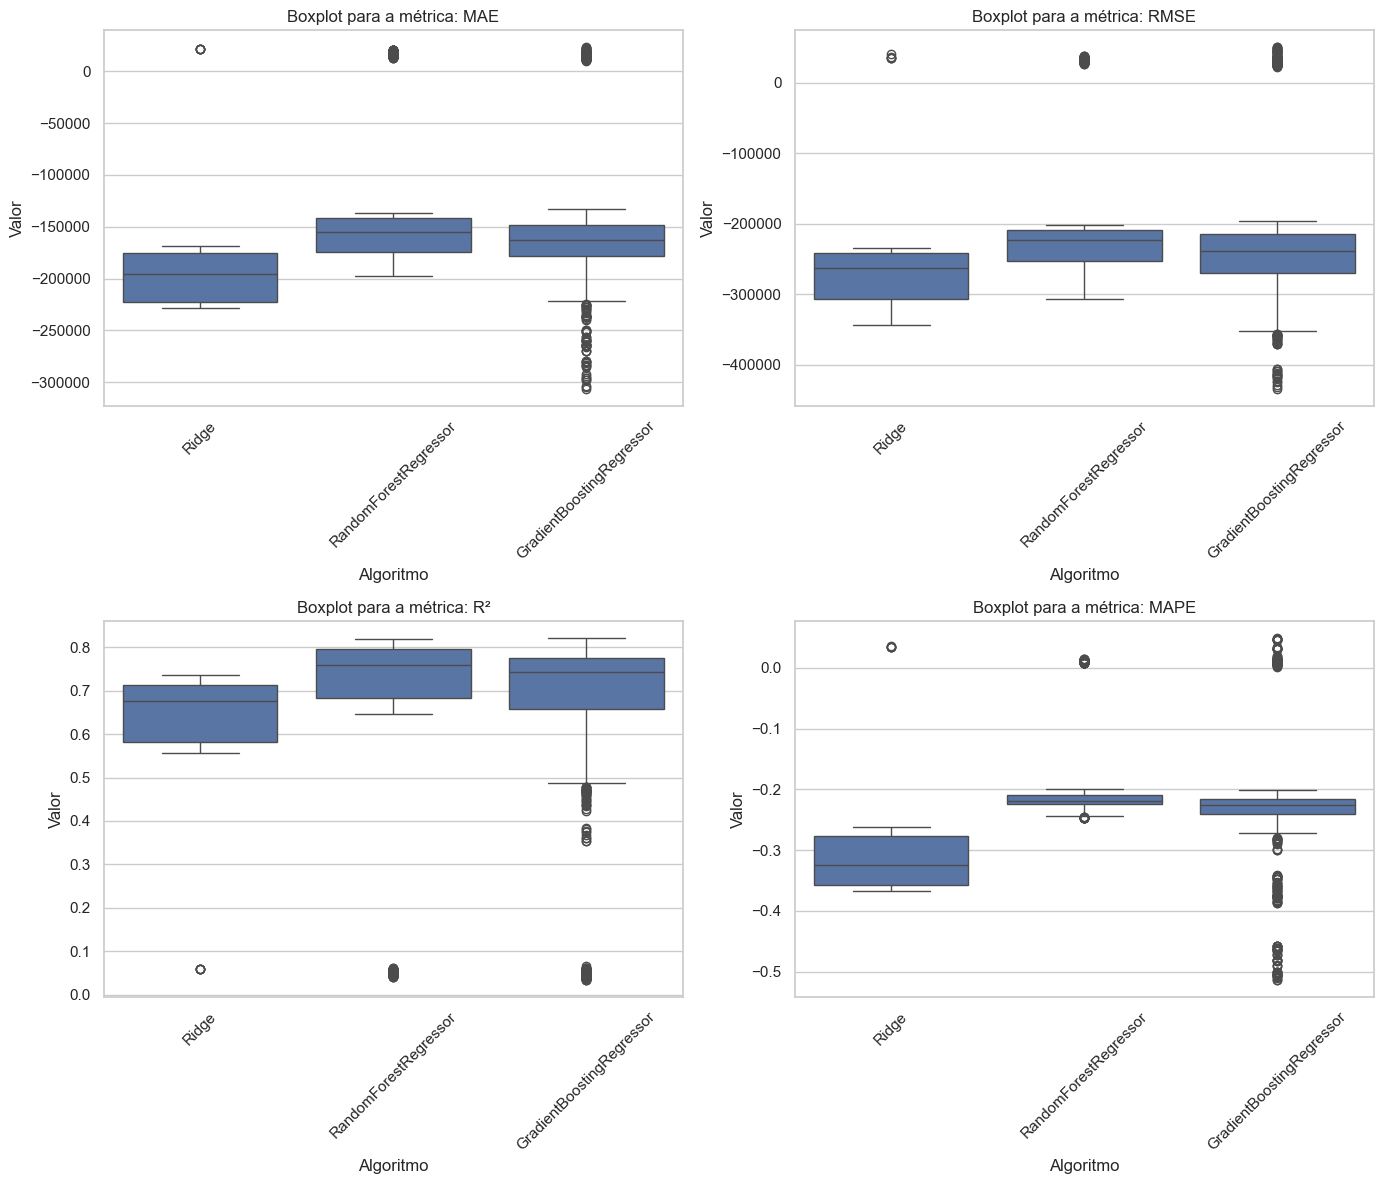

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math


# Ajustar o estilo dos plots
sns.set(style="whitegrid")

# Obter as métricas únicas
metricas = dataframe_final['Métrica'].unique()

# Determinar o número de linhas e colunas
ncols = 2
nrows = math.ceil(len(metricas) / ncols)  # Calcula o número de linhas necessário

# Criar uma grade de subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
axes = axes.flatten()  # Achatar o array de eixos para facilitar o loop

# Criar um boxplot para cada métrica
for i, metrica in enumerate(metricas):
    sns.boxplot(
        data=dataframe_final[dataframe_final['Métrica'] == metrica],
        x='Algoritmo',
        y='Valor',
        ax=axes[i]
    )
    axes[i].set_title(f"Boxplot para a métrica: {metrica}")
    axes[i].set_ylabel("Valor")
    axes[i].set_xlabel("Algoritmo")
    axes[i].tick_params(axis='x', rotation=45)

# Remover eixos extras, caso existam
for j in range(len(metricas), len(axes)):
    fig.delaxes(axes[j])

# Ajustar o layout para evitar sobreposição
plt.tight_layout()
plt.show()
